Copyright 2023 Google LLC

Use of this source code is governed by an MIT-style
license that can be found in the LICENSE file or at
https://opensource.org/licenses/MIT.

# Instructions
Please run the following cells sequentially
1. (Optional) Running 1b adds semantic labels and requires addtional resources (default to a second GPU).
* The function relies on an additonal image captioning model, e.g., BLIP.  
* The labels are nouns, extracted from the generated caption. 
* It merge masks sharing the same label. 
2. Add your own image and update ``image_path`` variable. 
3. Feel free to play with DiffSeg hyper-parameters such as the ``KL_THRESHOLD``.

# Import

In [1]:
# Common
import tensorflow as tf
from PIL import Image
import os, sys
# Datasets
import nltk
# Transformers
from transformers import AutoProcessor, TFBlipForConditionalGeneration
# AutoEncoders (AE)
from keras_cv.src.models.stable_diffusion.image_encoder import ImageEncoder
# Third party
from third_party.keras_cv.stable_diffusion import StableDiffusion 
from third_party.keras_cv.diffusion_model import SpatialTransformer
from third_party.taesd.taesd import TAESD
from third_party.taesd.wrapper_vae import WrapperVAE
# Local
from diffseg.utils import process_image, augmenter, vis_without_label, semantic_mask
from diffseg.segmentor import DiffSeg

is_noun = lambda pos: pos[:2] == 'NN'
!nvidia-smi
nltk.download('all')

2024-07-25 20:59:40.332557: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 20:59:40.332608: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 20:59:40.337038: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 20:59:40.764954: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ubuntu/miniconda3/envs/diffseg/lib/p

Using TensorFlow backend


2024-07-25 20:59:55.110932: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/ubuntu/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/ubuntu/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/ubuntu/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/ubuntu/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/ubuntu/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_dat

True

# 1. Initialize SD Model

In [2]:
# Inialize Stable Diffusion Model on GPU:0 
with tf.device('/GPU:0'):

  # image_encoder = ImageEncoder() # Original VAE keras/tf default
  # vae=tf.keras.Model(
  #   image_encoder.input,
  #   image_encoder.layers[-1].output,
  # )

  taesd = TAESD() # Define third party TAESD AE
  wrapper_vae = WrapperVAE(taesd) # Define wrapper for PyTorch <> Keras/tf
  inputs = tf.keras.Input(shape=(512, 512, 3))
  vae_outputs = wrapper_vae(inputs)

  # Define VAE Model
  vae=tf.keras.Model(
    inputs=inputs,
    outputs=vae_outputs,
  )

  # VAE summary
  vae.summary()

  # Stable Diffusion model
  model = StableDiffusion(img_width=512, img_height=512)
blip = None

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 wrapper_vae (WrapperVAE)    (None, None, None, 4)     0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [3]:
import torch
from diffusers import StableDiffusionPipeline

# Load Stable Diffusion pipeline with the bk-sdm-tiny model
# model = StableDiffusionPipeline.from_pretrained("nota-ai/bk-sdm-tiny", torch_dtype=torch.float32)
# model.to("cuda" if torch.cuda.is_available() else "cpu")

def generate_image(prompt=None, batch_size=1, latent=None, timestep=300):
    # Generate images using the prompt
    feature_map_img = model(prompt, num_inference_steps=timestep, latents=latent, guidance_scale=7.5).images
    return feature_map_img


# 1b. Initialize BLIP (optional)

In [ ]:
# Optionally initalize a BLIP captioning model on GPU:1
with tf.device('/GPU:1'):
    processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    blip = TFBlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# 2. Run Inference on Real Images

In [5]:
# The first time running this cell will be slow
# because the model needs to download and loads pre-trained weights.

import time

image_path = "./images/intel_isef.jpg" # Specify the path to your image

#------------------------------------------------------------------------------#

# [] [] [] Benchmarking vars/funcs [] [] [] #

process_times = {}

# Benchmark process helper function
def benchmark_process(process_name, process_func):
    start_time = time.time()
    result = process_func()
    process_times[process_name] = time.time() - start_time
    return result

#------------------------------------------------------------------------------#

prompt = None
if blip is not None:
  with tf.device('/GPU:1'):
    def process_blip():
      inputs = processor(images=Image.open(image_path), return_tensors="tf")
      out = blip.generate(**inputs)
      return processor.decode(out[0], skip_special_tokens=True)

    prompt = benchmark_process('BLIP Processing', process_blip)
    print(prompt)

#------------------------------------------------------------------------------#

with tf.device('/GPU:0'):
  # Image processing
  images = benchmark_process('Image Processing', lambda: process_image(image_path))
  # Image augmentation
  images = benchmark_process('Augmentation', lambda: augmenter(images))
  # Latent autoencoding
  latent_tf = benchmark_process('Autoencoder', lambda: vae(tf.expand_dims(images, axis=0), training=False))
  latent_pt = torch.tensor(latent_tf.numpy()).to(torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")

  def image_generation():
    return model.text_to_image(
      prompt,
      batch_size=1,
      latent=latent_tf,
      timestep=300
    )

  images, weight_64, weight_32, weight_16, weight_8, x_weights_64, x_weights_32, x_weights_16, x_weights_8 = benchmark_process('Image Generation', image_generation)
  
  """
  def image_generation():
    return generate_image(
      prompt,
      batch_size=1,
      latent=latent_pt,
      timestep=300
    )

  images = benchmark_process('Image Generation', image_generation)
  """

# Visualize the processing times in table format
print(f"{'Process':<20} | {'Time (s)':>10}")
print("-" * 35)
for process, t in process_times.items():
    print(f"{process:<20} | {t:>10.4f}")

Process              |   Time (s)
-----------------------------------
Image Processing     |     0.2630
Augmentation         |     0.0055
Autoencoder          |     1.3600
Image Generation     |    29.3010


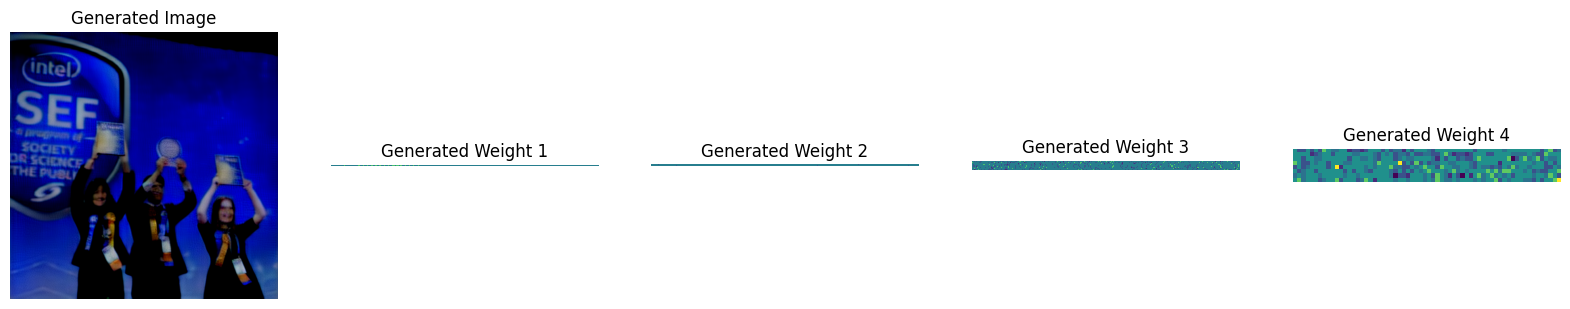

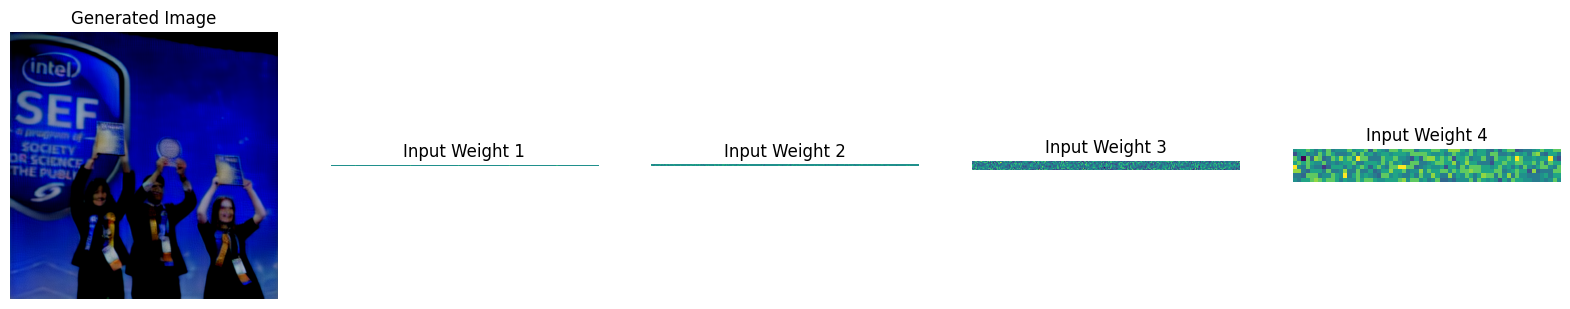

In [6]:
# Visualization of weights

import matplotlib.pyplot as plt
import numpy as np

# Function to plot the images and weights
def plot_images_and_weights(images, weights, title):
  fig, axes = plt.subplots(1, len(weights)+1, figsize=(20, 5))
  axes[0].imshow(images[0])
  axes[0].set_title('Generated Image')
  axes[0].axis('off')

  for i, weight in enumerate(weights):
    axes[i+1].imshow(np.mean(weight[0], axis=2)) # Averaging over the channels
    axes[i+1].set_title(f'{title} Weight {i+1}')
    axes[i+1].axis('off')

  plt.show()

# Plotting generated images and weights
plot_images_and_weights(images, [weight_64, weight_32, weight_16, weight_8], 'Generated')
plot_images_and_weights(images, [x_weights_64, x_weights_32, x_weights_16, x_weights_8], 'Input')

# 3. Generate Segementation Masks

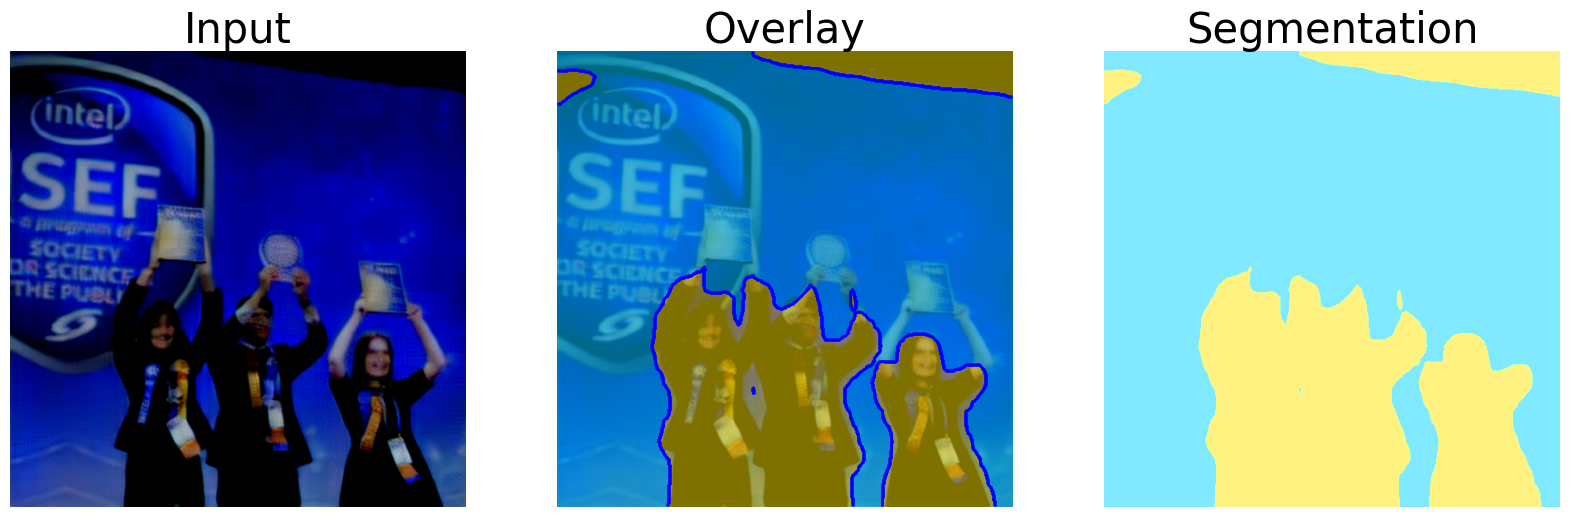

In [7]:
KL_THRESHOLD = [0.9]*3 # KL_THRESHOLD controls the merging threshold
NUM_POINTS = 16
REFINEMENT = True

with tf.device('/GPU:0'):
  segmentor = DiffSeg(KL_THRESHOLD, REFINEMENT, NUM_POINTS)
  pred = segmentor.segment(weight_64, weight_32, weight_16, weight_8) # b x 512 x 512
  if blip is not None:
    tokenized = nltk.word_tokenize(prompt)
    nouns = [(i,word) for i,(word, pos) in enumerate(nltk.pos_tag(tokenized)) if is_noun(pos)] 

  for i in range(len(images)):
    if blip is not None:
      x_weight = segmentor.aggregate_x_weights([x_weights_64[i],x_weights_32[i], x_weights_16[i], x_weights_8[i]],weight_ratio=[1.0,1.0,1.0,1.0])
      label_to_mask = segmentor.get_semantics(pred[i], x_weight[i], nouns, voting="mean")
      semantic_mask(images[i], pred[i], label_to_mask)
    vis_without_label(pred[i],images[i],num_class=len(set(pred[i].flatten())))